In [1]:
import numpy                   as np
import pandas                  as pd
import netCDF4                 as nc
import matplotlib.pyplot       as plt
from sklearn.metrics           import root_mean_squared_error
from ISLP.torch                import (SimpleDataModule,SimpleModule,ErrorTracker,rec_num_workers)
import torch
from torch                     import nn
from torch.optim               import RMSprop
from torch.utils.data          import TensorDataset
from torchinfo                 import summary
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning         import Trainer
from pytorch_lightning         import seed_everything

In [2]:
# For fair comparision with others, do not change seed number !!!
seed_everything(0, workers=True)
torch.use_deterministic_algorithms(True, warn_only=True)

Seed set to 0


In [3]:
# load constant
OneHour  = 3600

# load monthly mean precipitation over the Beijing region as output
FileNam1 = f'mtpr_ERA5.nc'
ds       = nc.Dataset(FileNam1)
# print(ds['mtpr'])
mtpr     = OneHour*ds['mtpr'][:]  # change unit kg/m2/s to mm/hr
Y        = np.mean(mtpr,axis=(1,2))
Y        = Y[:,np.newaxis]        # required by CNN 
print('Shape of Y: ',Y.shape)
ds.close()

# load monthly mean total column water vapor over the Beijing region as input (first channel)
FileNam2 = f'tcwv_ERA5.nc'
ds       = nc.Dataset(FileNam2)
# print(ds['tcwv'])
X1       = ds['tcwv'][:]         # change unit kg/m2 to mm
print('Shape of X1: ',X1.shape)
ds.close()

# load monthly mean 2-meter temperature over the Beijing region as input (second channel)
FileNam3 = f't2m_ERA5.nc'
ds       = nc.Dataset(FileNam3)
# print(ds['t2m'])               # unit: K
X2       = ds['t2m'][:]
print('Shape of X2: ',X2.shape)
ds.close()

# combine X1 and X2
X = np.stack((X1,X2),axis=1)

Shape of Y:  (276, 1)
Shape of X1:  (276, 41, 41)
Shape of X2:  (276, 41, 41)


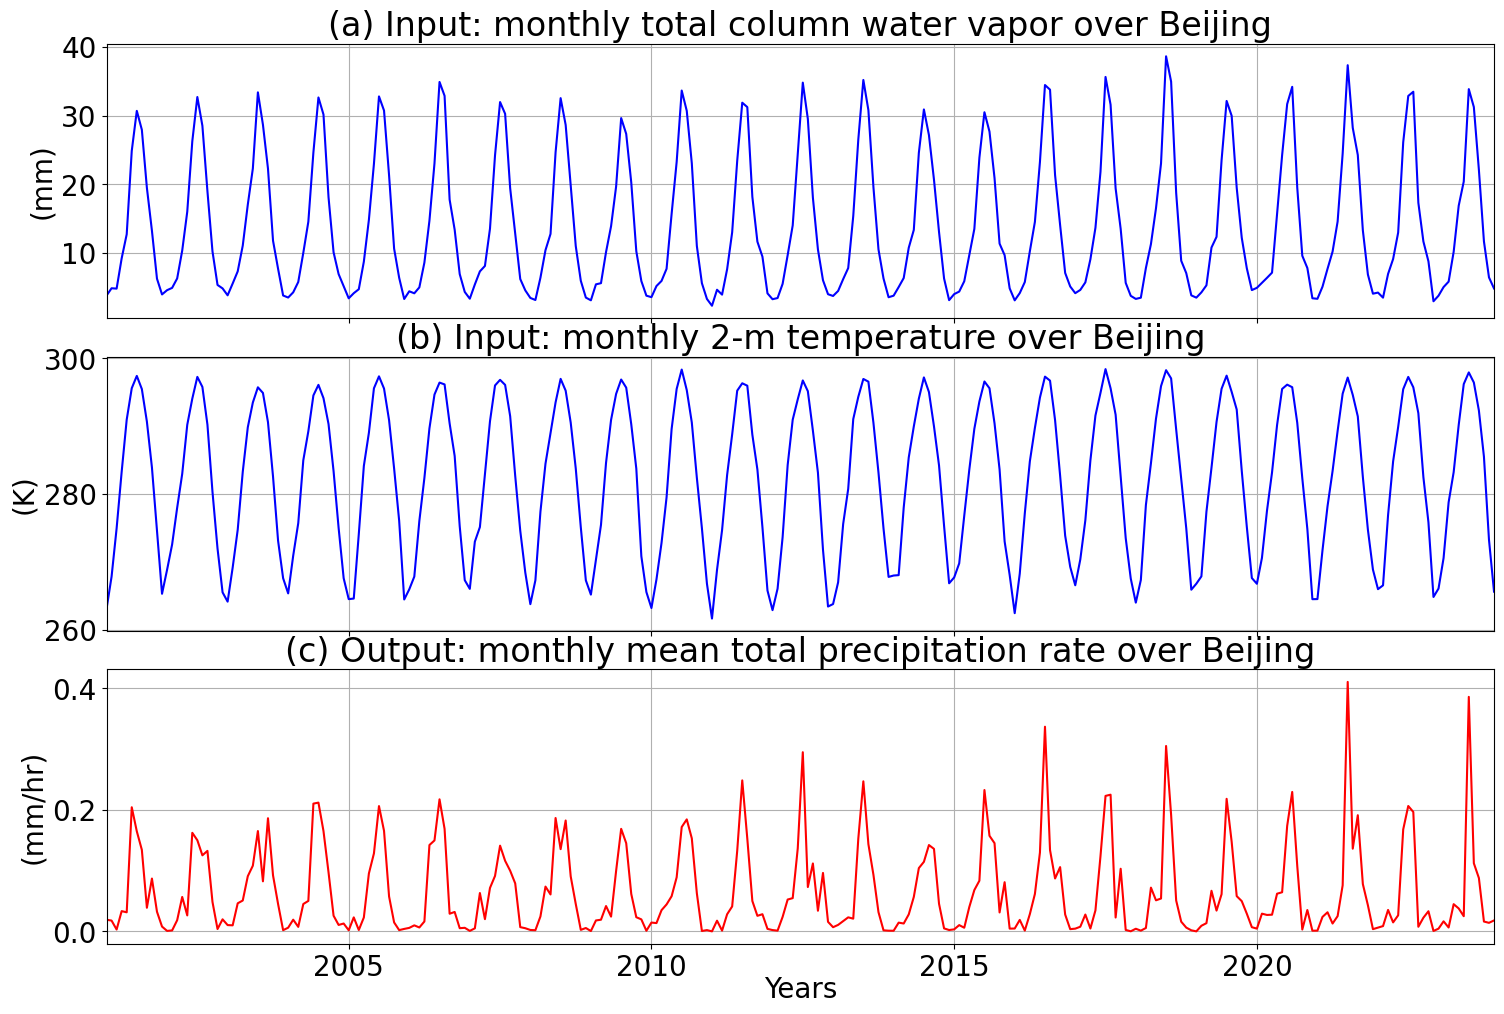

In [4]:
# plot time series
plt.rcParams['font.size'] = '20'
fig, ax = plt.subplots(3,1,figsize=(15,10)) 
plt.subplots_adjust(left=0.065,bottom=0.060,right=0.990,top=0.960,wspace=0.04,hspace=0.14)

tg      = np.linspace(2001,2024,12*23,endpoint=False)

ir = 0
Xm = np.mean(X1,axis=(1,2))
ax[ir].plot(tg,Xm,'b')
ax[ir].set_xlim([tg[0],tg[-1]])
ax[ir].grid(which='both')
ax[ir].set_ylabel('(mm)')
ax[ir].set_title('(a) Input: monthly total column water vapor over Beijing')
ax[ir].set_xticks([2005,2010,2015,2020]);
ax[ir].set_xticklabels([])

ir = 1
Xm = np.mean(X2,axis=(1,2))
ax[ir].plot(tg,Xm,'b')
ax[ir].set_xlim([tg[0],tg[-1]])
ax[ir].grid('both')
ax[ir].set_ylabel('(K)')
ax[ir].set_title('(b) Input: monthly 2-m temperature over Beijing')
ax[ir].set_xticks([2005,2010,2015,2020]);
ax[ir].set_xticklabels([])

ir = 2
ax[ir].plot(tg,Y,'r')
ax[ir].set_xlim([tg[0],tg[-1]])
ax[ir].grid('both')
ax[ir].set_xlabel('Years',labelpad=-4)
ax[ir].set_ylabel('(mm/hr)')
ax[ir].set_title('(c) Output: monthly mean total precipitation rate over Beijing')
ax[ir].set_xticks([2005,2010,2015,2020]);

plt.savefig('plotting_input_output.png')

In [5]:
# separate into training and test dataset
X_train = X[   0:240,:,:,:]
Y_train = Y[   0:240]
X_test  = X[240:None,:,:,:]
Y_test  = Y[240:None]

X_train_t = torch.tensor(X_train.astype(np.float32))
Y_train_t = torch.tensor(Y_train.astype(np.float32))
X_test_t  = torch.tensor(X_test.astype(np.float32))
Y_test_t  = torch.tensor(Y_test.astype(np.float32))

bj_train = TensorDataset(X_train_t, Y_train_t)
bj_test  = TensorDataset(X_test_t,  Y_test_t)

In [6]:
max_num_workers = rec_num_workers()
bj_dm           = SimpleDataModule(bj_train,
                                   bj_test,
                                   validation=0.2,
                                   num_workers=max_num_workers,
                                   batch_size=128)

# check training data
for idx, (X_ ,Y_) in enumerate(bj_dm.train_dataloader()):
    print('X: ', X_.shape)
    print('Y: ', Y_.shape)

X:  torch.Size([128, 2, 41, 41])
Y:  torch.Size([128, 1])
X:  torch.Size([64, 2, 41, 41])
Y:  torch.Size([64, 1])


In [7]:
class BuildingBlock(nn.Module):

    def __init__(self,
                 in_channels,
                 out_channels):

        super(BuildingBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels=in_channels,
                              out_channels=out_channels,
                              kernel_size=(3,3),
                              padding='same')
        self.activation = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=(2,2))

    def forward(self, x):
        return self.pool(self.activation(self.conv(x)))

In [8]:
class BJModel(nn.Module):

    def __init__(self):
        super(BJModel, self).__init__()
        sizes = [(2,32),
                 (32,64),
                 (64,128),
                 (128,256)]
        self.conv = nn.Sequential(*[BuildingBlock(in_, out_)
                                    for in_, out_ in sizes])

        self.output = nn.Sequential(nn.Dropout(0.5),
                                    nn.Linear(2*2*256, 512),
                                    nn.ReLU(),
                                    nn.Linear(512, 1))
    def forward(self, x):
        val = self.conv(x)
        val = torch.flatten(val, start_dim=1)
        return self.output(val)

In [9]:
bj_model = BJModel()
summary(bj_model,
        input_data=X_,
        col_names=['input_size',
                   'output_size',
                   'num_params'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
BJModel                                  [64, 2, 41, 41]           [64, 1]                   --
├─Sequential: 1-1                        [64, 2, 41, 41]           [64, 256, 2, 2]           --
│    └─BuildingBlock: 2-1                [64, 2, 41, 41]           [64, 32, 20, 20]          --
│    │    └─Conv2d: 3-1                  [64, 2, 41, 41]           [64, 32, 41, 41]          608
│    │    └─ReLU: 3-2                    [64, 32, 41, 41]          [64, 32, 41, 41]          --
│    │    └─MaxPool2d: 3-3               [64, 32, 41, 41]          [64, 32, 20, 20]          --
│    └─BuildingBlock: 2-2                [64, 32, 20, 20]          [64, 64, 10, 10]          --
│    │    └─Conv2d: 3-4                  [64, 32, 20, 20]          [64, 64, 20, 20]          18,496
│    │    └─ReLU: 3-5                    [64, 64, 20, 20]          [64, 64, 20, 20]          --
│    │    └─MaxPool2d: 3-6    

In [10]:
bj_optimizer = RMSprop(bj_model.parameters(), lr=0.001)
bj_module    = SimpleModule.regression(bj_model,
                                       optimizer=bj_optimizer)
bj_logger    = CSVLogger('logs', name='bj')

In [11]:
max_epochs   = 1000
bj_trainer   = Trainer(deterministic=True,
                       max_epochs=max_epochs,
                       logger=bj_logger,
                       enable_progress_bar=False,
                       callbacks=[ErrorTracker()],
                       log_every_n_steps=1)
bj_trainer.fit(bj_module, datamodule=bj_dm)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type    | Params | Mode 
------------------------------------------
0 | model | BJModel | 913 K  | train
1 | loss  | MSELoss | 0      | train
------------------------------------------
913 K     Trainable params
0         Non-trainable params
913 K     Total params
3.654     Total estimated model params size (MB)
24        Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=1000` reached.


In [12]:
log_path   = bj_logger.experiment.metrics_file_path
bj_results = pd.read_csv(log_path)
bj_results

epoch  step    train_loss  valid_loss
0         0     1           NaN  263.914001
1         0     1  6.873662e+06         NaN
2         1     3           NaN   14.052769
3         1     3  1.675682e+05         NaN
4         2     5           NaN   41.222237
...     ...   ...           ...         ...
1995    997  1995  1.476033e-03         NaN
1996    998  1997           NaN    0.001260
1997    998  1997  1.172318e-03         NaN
1998    999  1999           NaN    0.001966
1999    999  1999  1.089175e-03         NaN

[2000 rows x 4 columns]

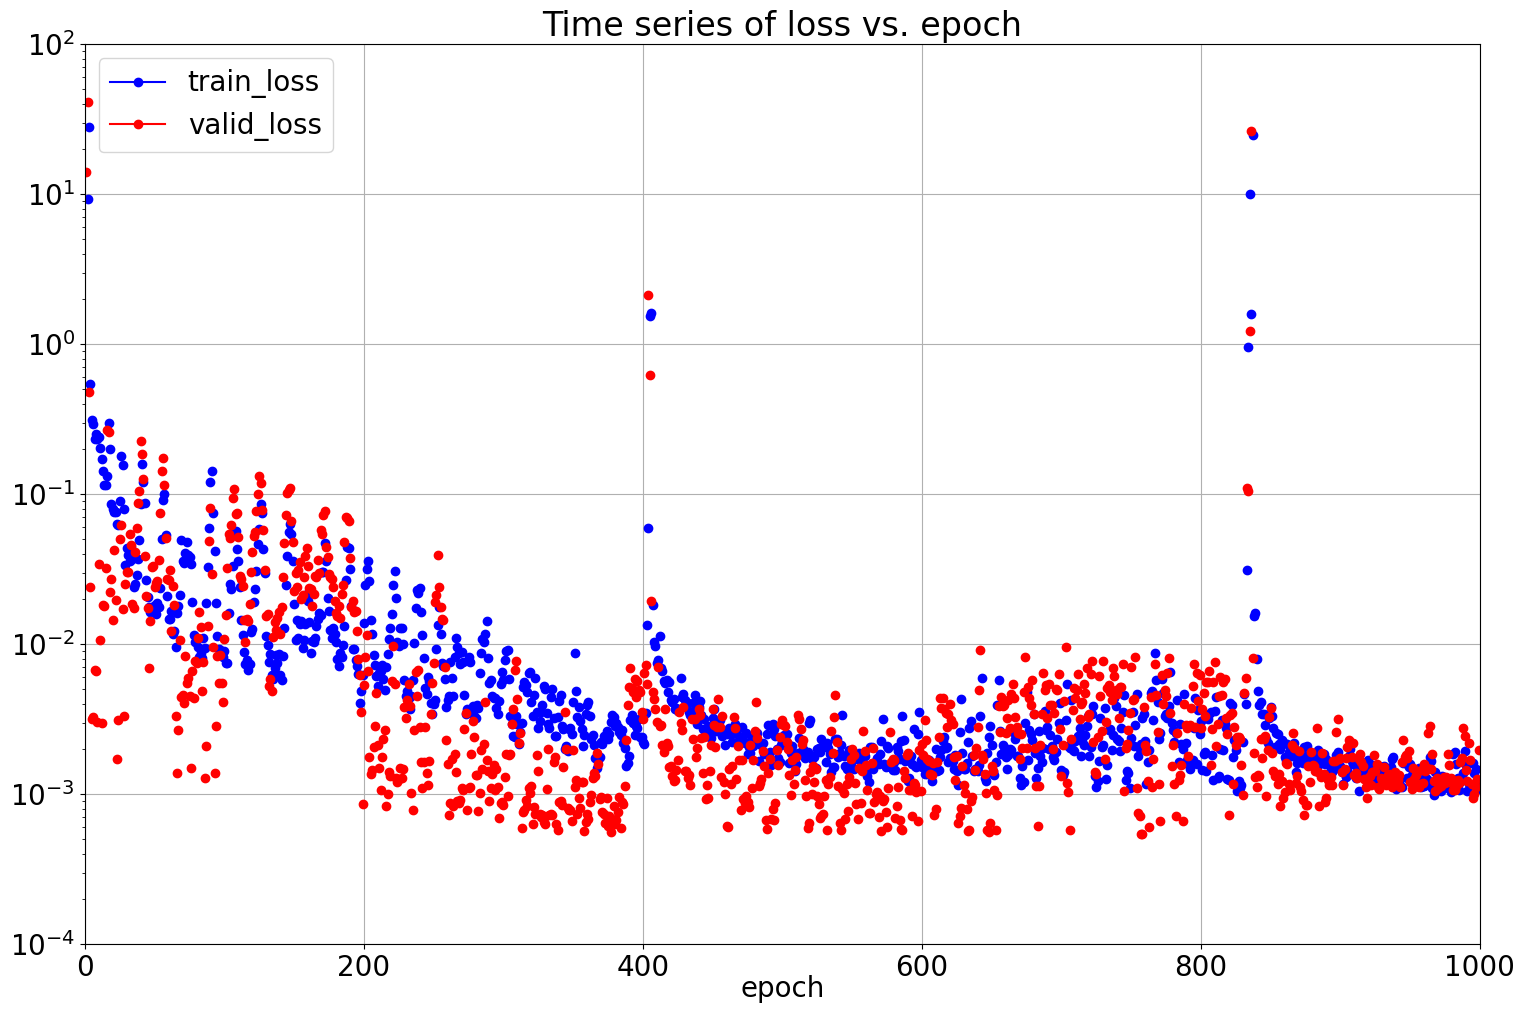

In [13]:
# plot results
plt.rcParams['font.size'] = '20'
fig, ax = plt.subplots(figsize=(15,10)) 
plt.subplots_adjust(left=0.050,bottom=0.060,right=0.980,top=0.960,wspace=0.04,hspace=0.10)

bj_results.plot(x='epoch',y=['train_loss','valid_loss'],label=['train_loss','valid_loss'],marker='o',color=['b','r'],logy=True,ax=ax)
ax.set_xlabel('epoch',labelpad=-5)
ax.set_xlim([0,max_epochs]);
ax.set_ylim([1e-4, 1e2]);
ax.grid()
ax.set_title('Time series of loss vs. epoch')

plt.savefig('plotting_train_loss.png')

In [14]:
# use default command to evaluate error
bj_trainer.test(bj_module,datamodule=bj_dm)

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss          0.004653874319046736
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.004653874319046736}]

Root mean square error of test data is 6.82e-02!


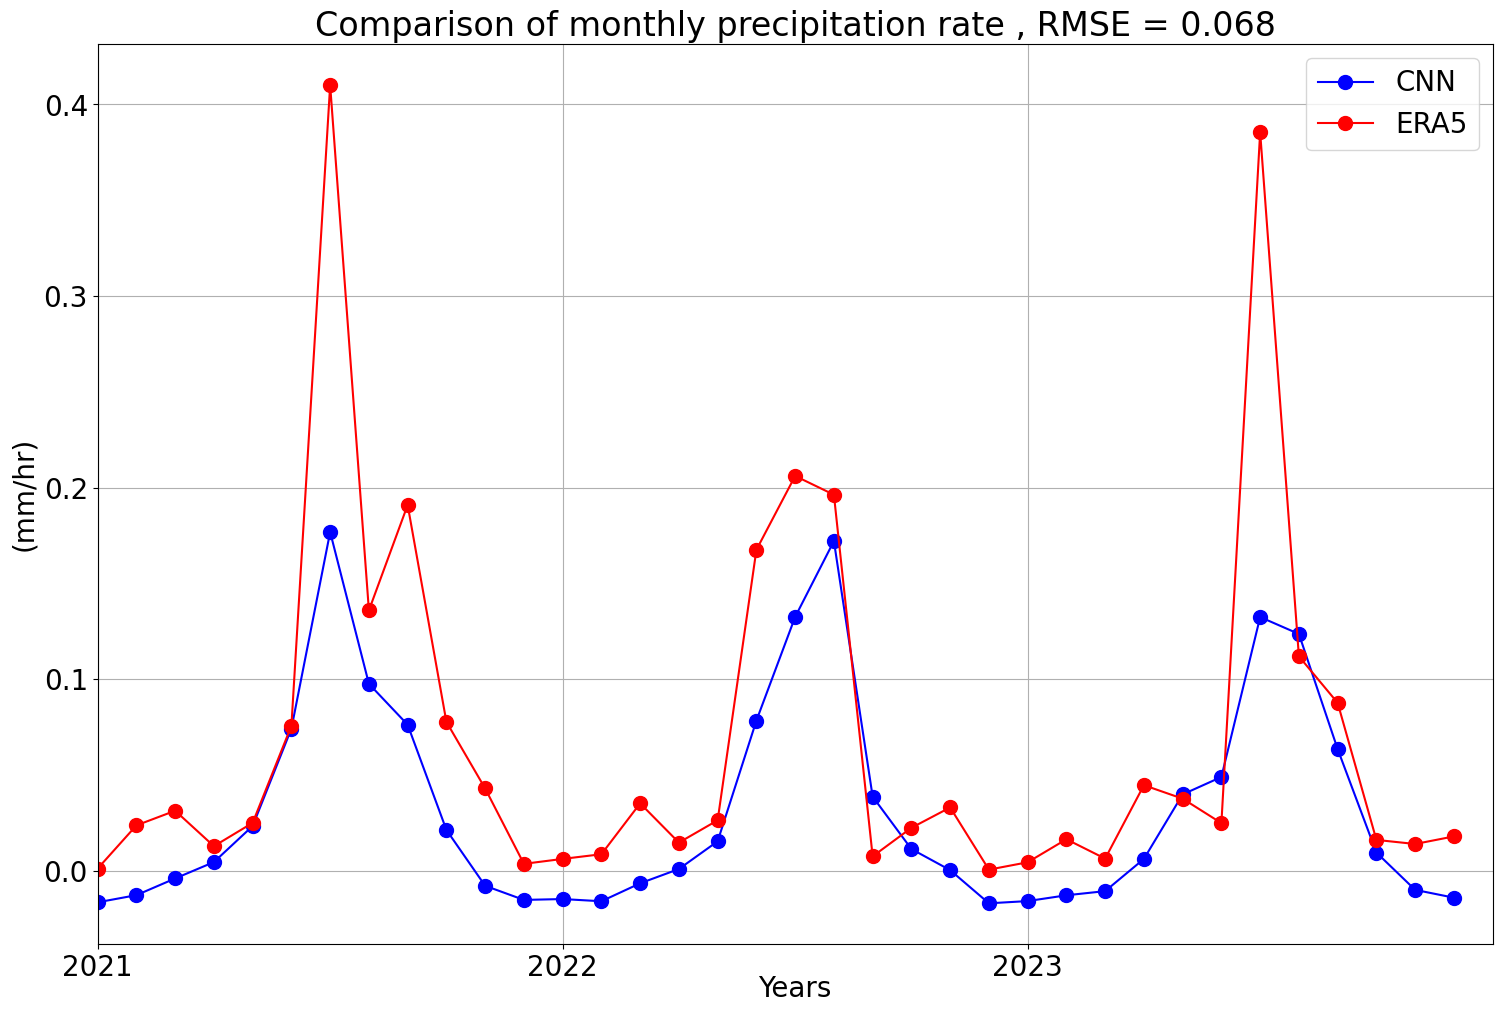

In [15]:
# calculate the difference
bj_model.eval() 
with torch.no_grad():
    Y_pred = bj_module(X_test_t).detach().cpu().numpy()
    Y_test = Y_test_t.detach().cpu().numpy()

rmse = root_mean_squared_error(Y_test, Y_pred)
print(f'Root mean square error of test data is {rmse:.2e}!')

# plot time series
plt.rcParams['font.size'] = '20'
fig, ax = plt.subplots(figsize=(15,10)) 
plt.subplots_adjust(left=0.060,bottom=0.060,right=0.990,top=0.960,wspace=0.04,hspace=0.14)

ax.plot(tg[240:None],Y_pred,'ob-',ms=10,label='CNN')
ax.plot(tg[240:None],Y_test,'or-',ms=10,label='ERA5')
ax.grid()
ax.legend()
ax.set_xlim([2021,2024])
ax.set_xlabel('Years',labelpad=-5)
ax.set_ylabel('(mm/hr)')
ax.set_title(f'Comparison of monthly precipitation rate , RMSE = {rmse:.3f}');
ax.set_xticks([2021,2022,2023]);

plt.savefig('plotting_test_error.png')